# Mobile Operator Tariff Recommendation System

The mobile operator offers two tariff plans: 'Smart' and 'Ultra'.  
We need to conduct a preliminary analysis of the tariffs on a small sample of customers and analyze which tariff is more promising for the operator. We will also build a model that recommends the appropriate tariff to users.

**Tariff Descriptions**  
`Smart Tariff`  
Monthly fee: 15 euros  
Includes 500 minutes of calls, 50 messages, and 15 GB of internet traffic  
Additional charges for services exceeding the tariff package:  
Minute of call - 0.1 euros  
Message - 0.1 euros  
1 GB of internet traffic - 6 euros  
`Ultra Tariff`  
Monthly fee: 50 euros  
Includes 3000 minutes of calls, 1000 messages, and 30 GB of internet traffic  
Additional charges for services exceeding the tariff package:  
Minute of call - 0.05 euros  
Message - 0.05 euros  
1 GB of internet traffic - 4 euros  

### Exploratory Data Analysis

**Import Packages**

In [113]:
import os
import matplotlib.pyplot as plt
import numpy as np

from category_encoders import TargetEncoder
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from scipy import stats as st

Load the dataset and evaluate the data

In [114]:
BASE_DIR = os.getcwd()

calls = pd.read_csv(f'{BASE_DIR}/datasets/calls.csv')
sessions = pd.read_csv(f'{BASE_DIR}/datasets/internet.csv')
messages = pd.read_csv(f'{BASE_DIR}/datasets/messages.csv')
tariffs = pd.read_csv(f'{BASE_DIR}/datasets/tariffs.csv')
users = pd.read_csv(f'{BASE_DIR}/datasets/users.csv')

### Analyzing Call Data

In [115]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [116]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Evaluate the distribution of call duration

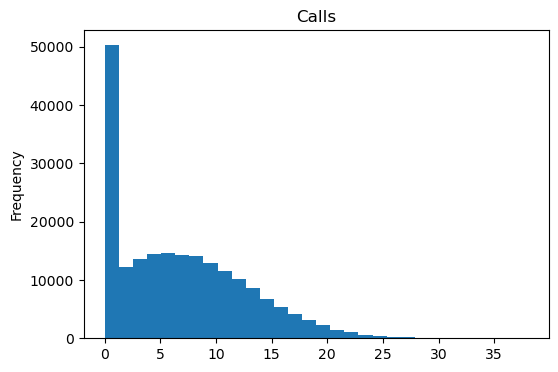

In [117]:
calls['duration'].plot(kind='hist', figsize=(6, 4), title="Calls", bins=30);

The distribution appears to follow a natural pattern - a Poisson distribution with a peak around 0.

### Analyzing Internet Usage Data

In [118]:
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [119]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


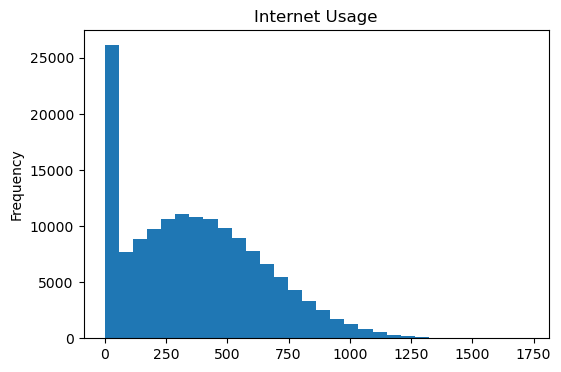

In [120]:
sessions['mb_used'].plot(kind='hist', figsize=(6,4), title="Internet Usage",bins=30);

The distribution appears to follow a natural pattern - a Poisson distribution with a peak around 0.

### Analyzing Message Usage Data

In [121]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [122]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


### Analyzing Tariff Data

In [123]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Analyzing User Data

In [124]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [125]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Data Preparation

Convert date features to `datetime` type

In [126]:
# Processing the 'reg_date' column
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# Processing the 'churn_date' column
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# Processing the 'call_date' column
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# Processing the 'message_date' column
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# Processing the 'session_date' column
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format='%Y-%m-%d')

There are calls with zero duration in the data, which are missed calls, so they don't need to be removed. Round up the call durations to the nearest whole number.

In [127]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)

Remove unnecessary column `Unnamed: 0`

In [128]:
sessions = sessions.drop('Unnamed: 0', axis=1)

### Aggregated Data by Months

Create a `month` column in the `calls`, `messages`, and `sessions` dataframes

In [129]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
sessions['month'] = pd.DatetimeIndex(sessions['session_date']).month

Number of calls per user per month

In [130]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))
calls_per_month.head(30)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33
        11        32
        12        33
1003    8         55
        9        134
        10       108
        11       115
        12       108
1004    5          9
        6         31
        7         22
        8         19
        9         26
        10        29
        11        19
        12        21

Number of minutes per user per month

In [131]:
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))
minutes_per_month.head(30)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212
        11         243
        12         236
1003    8          380
        9          961
        10         855
        11         824
        12         802
1004    5           35
        6          171
        7          135
        8          137
        9          117
        10         145
        11         117
        12         130

Number of messages sent per user per month

In [132]:
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))
messages_per_month.head(30)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12
1003    8            37
        9            91
        10           83
        11           94
        12           75
1004    5            95
        6           134
        7           181
        8           151
        9           146
        10          165
        11          158
        12          162
1005    1             7
        2            38

Number of megabytes used per user per month

In [133]:
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})
sessions_per_month.head(30)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25
        11     18587.28
        12     18113.73
1003    8       8565.21
        9      12468.87
        10     14768.14
        11     11356.89
        12     10121.53
1004    5      13403.98
        6      17600.02
        7      22229.58
        8      28584.37
        9      15109.03
        10     18475.44
        11     15616.02
        12     18021.04

### Exploratory Data Analysis

Combine all the calculated values into one dataframe, `user_behavior`.
For each 'user - month' pair, there will be information about the tariff, number of calls, messages, and megabytes used.

In [134]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

7.6% of customers from the sample have terminated their contracts

In [135]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Check for missing values in the `user_behavior` table after merging:

In [136]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Fill in the missing data:

In [137]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Join tariff information

In [138]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [139]:
user_behavior = user_behavior.merge(tariffs, on='tariff')

Calculate the number of minutes, messages, and gigabytes exceeding the included package


In [140]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - \
    user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - \
    user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - \
    user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Convert exceeding megabytes to gigabytes and save them in the `paid_gb` column

In [141]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Calculate revenue for minutes, messages, and internet usage

In [142]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * \
    user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * \
    user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * \
    user_behavior['rub_per_gb']

Calculate monthly revenue per user, stored in the `total_cost` column

In [143]:
user_behavior['total_cost'] = \
    user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

The `stats_df` dataframe will store the main characteristics for each 'month-tariff' pair

In [144]:
# Saving statistical metrics for each month-tariff pair
# in a single table `stats_df` (mean value, standard deviation, median)

stats_df = user_behavior.pivot_table(
    index=['month', 'tariff'],
    values=['calls', 'minutes', 'messages', 'mb_used'],
    aggfunc=['mean', 'std', 'median']
).round(2).reset_index()

stats_df.columns = ['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                    'calls_std',  'sessions_std', 'messages_std', 'minutes_std',
                    'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
8,5,smart,55.24,15805.18,33.77,387.36,25.38,5978.23,27.04,186.60,59.0,16323.94,30.0,433.0
9,5,ultra,72.51,19363.15,37.85,510.33,41.08,10046.11,40.31,289.60,75.0,18696.43,25.0,519.0


Analyze the distribution of average number of calls by tariff type and month

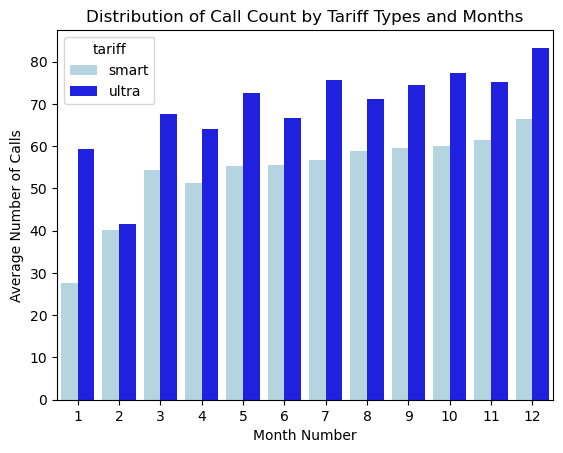

In [145]:
ax = sns.barplot(x='month',
                 y='calls_mean',
                 hue="tariff",
                 data=stats_df,
                 palette=['lightblue', 'blue']);

ax.set_title('Distribution of Call Count by Tariff Types and Months');
ax.set(xlabel='Month Number', ylabel='Average Number of Calls');

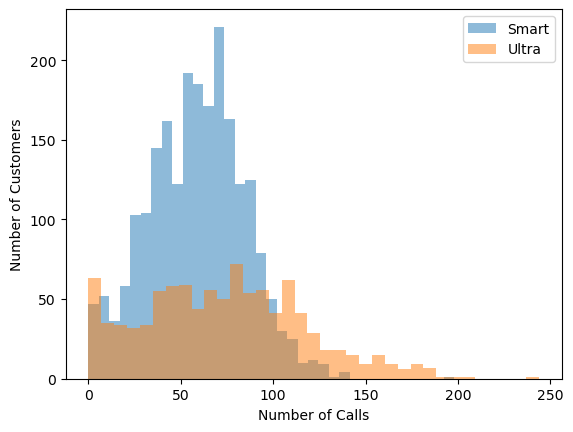

In [146]:
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Number of Calls')
plt.ylabel('Number of Customers')
plt.show()

Analyze the distribution of average call duration by tariff type and month

[Text(0.5, 0, 'Month Number'), Text(0, 0.5, 'Average Call Duration')]

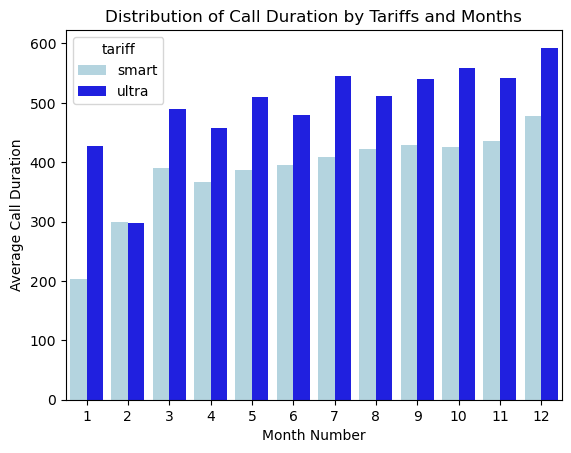

In [147]:
ax = sns.barplot(x='month',
                 y='minutes_mean',
                 hue="tariff",
                 data=stats_df,
                 palette=['lightblue', 'blue'])

ax.set_title(
    'Distribution of Call Duration by Tariffs and Months')
ax.set(xlabel='Month Number', ylabel='Average Call Duration')

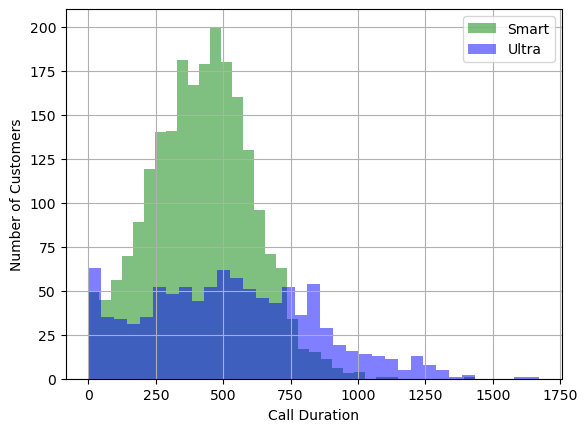

In [148]:
user_behavior[user_behavior['tariff'] == 'smart']['minutes'].hist(bins=35, alpha=0.5, color='green');
user_behavior[user_behavior['tariff'] == 'ultra']['minutes'].hist(bins=35, alpha=0.5, color='blue');

plt.legend(['Smart', 'Ultra'])
plt.xlabel('Call Duration')
plt.ylabel('Number of Customers')
plt.show()

The average call duration for Ultra tariff subscribers is higher than that for Smart tariff subscribers. Both tariff subscribers increase their average call duration throughout the year. The increase in average call duration for Smart tariff subscribers is linear throughout the year, while Ultra tariff subscribers do not show similar linear stability. It is worth noting that the lowest indicators for both tariff plans were observed in February.

Analyze the distribution of average number of messages by tariff type and month

[Text(0.5, 0, 'Month Number'), Text(0, 0.5, 'Average Number of Messages')]

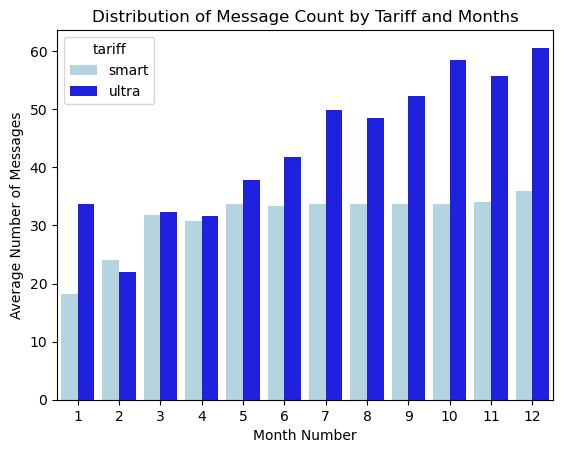

In [149]:
ax = sns.barplot(x='month',
                 y='messages_mean',
                 hue="tariff",
                 data=stats_df,
                 palette=['lightblue', 'blue']
                 )

ax.set_title('Distribution of Message Count by Tariff and Months')
ax.set(xlabel='Month Number', ylabel='Average Number of Messages')

Text(0.5, 1.0, 'Distribution of Message Count by Tariff')

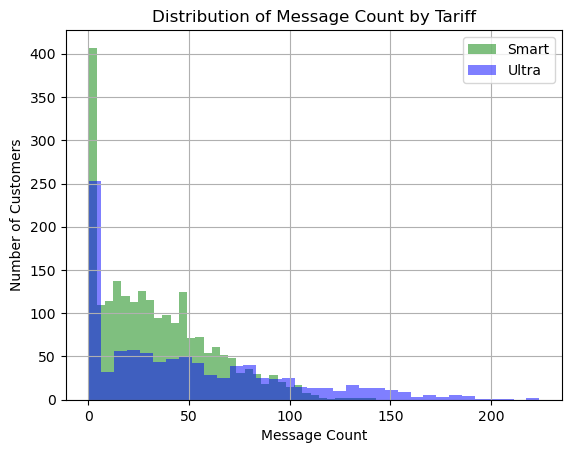

In [150]:
user_behavior[user_behavior['tariff'] == 'smart']['messages'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] == 'ultra']['messages'].hist(bins=35, alpha=0.5, color='blue')

plt.legend(['Smart', 'Ultra'])
plt.xlabel('Message Count')
plt.ylabel('Number of Customers')
plt.title('Distribution of Message Count by Tariff')

On average, users of the Ultra tariff plan send more messages - almost 20 messages more than Smart tariff users. The number of messages increases throughout the year for both tariffs. The messaging trends are similar to call duration trends: the lowest number of messages sent in a month was observed in February, and Ultra tariff users also show non-linear positive dynamics.

[Text(0.5, 0, 'Month Number'), Text(0, 0.5, 'Average Number of Megabytes')]

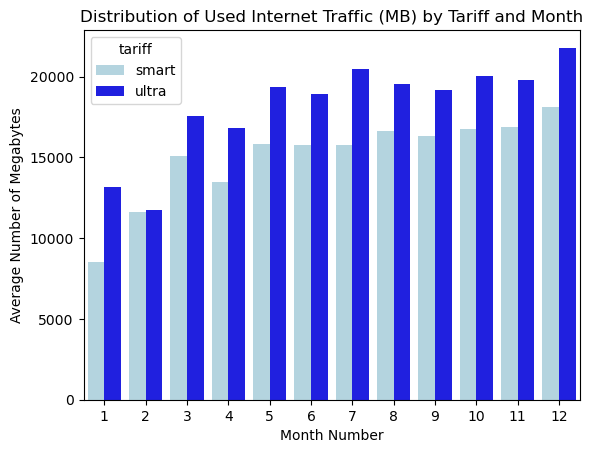

In [151]:
ax = sns.barplot(x='month',
                 y='sessions_mean',
                 hue="tariff",
                 data=stats_df,
                 palette=['lightblue', 'blue']
                 )

ax.set_title('Distribution of Used Internet Traffic (MB) by Tariff and Month')
ax.set(xlabel='Month Number', ylabel='Average Number of Megabytes')

Compare the usage of megabytes between Smart and Ultra tariff users

Text(0, 0.5, 'Average Number of Megabytes')

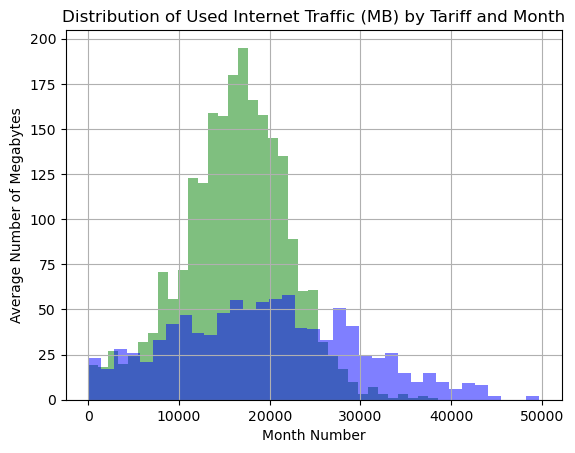

In [152]:
user_behavior[user_behavior['tariff'] == 'smart']['mb_used'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] == 'ultra']['mb_used'].hist(bins=35, alpha=0.5, color='blue')

plt.title('Distribution of Used Internet Traffic (MB) by Tariff and Month')
plt.xlabel('Month Number')
plt.ylabel('Average Number of Megabytes')

Users utilized the least amount of internet data in January, February, and April. Smart tariff subscribers tend to use 15-17 GB more frequently, while Ultra tariff subscribers use 19-21 GB.

Check if the average revenue differs between Ultra and Smart tariff users

In [153]:
results = st.ttest_ind(user_behavior[user_behavior['tariff'] == 'smart']['total_cost'],
                       user_behavior[user_behavior['tariff'] == 'ultra']['total_cost'],
                       equal_var=False)

alpha = 0.05

print(f'p-value = {results.pvalue}')
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

p-value = 4.2606313931076085e-250
We reject the null hypothesis


Compare revenue from Moscow users with revenue from users in other cities

In [154]:
results = st.ttest_ind(user_behavior[user_behavior['city'] == 'Москва']['total_cost'],
                       user_behavior[user_behavior['city'] != 'Москва']['total_cost'],
                       equal_var=False)

alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')

0.5257376663729298
We accept the null hypothesis


In [155]:
user_behavior.columns

Index(['user_id', 'month', 'calls', 'messages', 'mb_used', 'minutes', 'age',
       'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'paid_minutes', 'paid_messages', 'paid_mb', 'paid_gb', 'cost_minutes',
       'cost_messages', 'cost_gb', 'total_cost'],
      dtype='object')

In [156]:
df = user_behavior.copy()

Encoding can be done before the split since there are only two categories

In [157]:
cats = ['tariff']

encoder_ohe = OneHotEncoder(
    drop='first', handle_unknown='ignore', sparse=False
)

encoder_ohe.fit(df[cats])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [158]:
df['tariff'] = encoder_ohe.transform(df[cats])

In [159]:
df.columns

Index(['user_id', 'month', 'calls', 'messages', 'mb_used', 'minutes', 'age',
       'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'paid_minutes', 'paid_messages', 'paid_mb', 'paid_gb', 'cost_minutes',
       'cost_messages', 'cost_gb', 'total_cost'],
      dtype='object')

Remove uninformative features and features that directly indicate the currently used tariff by the user; otherwise, instead of recommending a tariff, we will obtain a model that accurately predicts the current tariff based on factors such as call cost or message cost.

In [160]:
df = df.drop(['month', 'first_name', 'last_name', 'churn_date', 'reg_date', 'user_id', 'rub_per_minute', 'rub_per_message', 'messages_included', 'mb_per_month_included', 'rub_monthly_fee', 'rub_per_gb', 'minutes_included', 'paid_minutes', 'paid_messages', 'paid_mb', 'paid_gb', 'cost_minutes', 'cost_messages', 'cost_gb', 'total_cost'], axis=1)

# Tariff Recommendation

The dataset contains customer data who have already switched to mobile operator tariffs. We need to build a classification model that selects the appropriate tariff for each customer.

The target metric is accuracy.

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   messages  3214 non-null   float64
 2   mb_used   3214 non-null   float64
 3   minutes   3214 non-null   float64
 4   age       3214 non-null   int64  
 5   city      3214 non-null   object 
 6   tariff    3214 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 200.9+ KB


## Data Splitting

In [162]:
df.columns

Index(['calls', 'messages', 'mb_used', 'minutes', 'age', 'city', 'tariff'], dtype='object')

In [163]:
target = df['tariff']
features = df.drop(['tariff'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print(
    features_train.shape,
    target_train.shape,
    features_valid.shape,
    target_valid.shape,
    features_test.shape,
    target_test.shape,
)

(1928, 6) (1928,) (643, 6) (643,) (643, 6) (643,)


The dataset is divided into `training`, `validation`, and `test` sets in a ratio of `3:1:1`.

In [164]:
cats = ['city']

encoder_ohe = TargetEncoder()

encoder_ohe.fit(features_train[cats], target_train)
features_train[cats] = encoder_ohe.transform(features_train[cats])
features_valid[cats] = encoder_ohe.transform(features_valid[cats])
features_test[cats] = encoder_ohe.transform(features_test[cats])

In [165]:
target_train.value_counts()

0.0    1342
1.0     586
Name: tariff, dtype: int64

We observe an imbalance in the dataset; however, it should be noted that the models considered below showed better results on the unbalanced dataset, so we will keep the dataset as it is.

## Model Training

We will train three models: logistic regression, decision tree, and random forest.

### Logistic Regression

In [166]:
features_train.columns

Index(['calls', 'messages', 'mb_used', 'minutes', 'age', 'city'], dtype='object')

In [167]:
target_train

2656    0.0
823     1.0
2566    0.0
1451    0.0
2953    0.0
       ... 
1043    0.0
2132    0.0
1642    0.0
1495    0.0
510     1.0
Name: tariff, Length: 1928, dtype: float64

In [168]:
model_log_reg = LogisticRegression(random_state = 1, solver='lbfgs', max_iter=1000)
model_log_reg.fit(features_train, target_train)

accuracy_log_reg = model_log_reg.score(features_valid, target_valid)
print(f'Accuracy = {accuracy_log_reg}')

Accuracy = 0.6982892690513219


After training the logistic regression model, we obtained an `accuracy` of 0.71.

### Decision Tree

In [169]:
for depth in range(1,15):
    model_dec_tree = DecisionTreeClassifier(random_state = 1, max_depth = depth)
    model_dec_tree.fit(features_train, target_train)
    prediction = model_dec_tree.predict(features_valid)

    accuracy_dec_tree = accuracy_score(prediction, target_valid)
    print(f'Accuracy = {round(accuracy_dec_tree,5)}, at max_depth = {depth}')

Accuracy = 0.72162, at max_depth = 1
Accuracy = 0.75739, at max_depth = 2
Accuracy = 0.79005, at max_depth = 3
Accuracy = 0.81182, at max_depth = 4
Accuracy = 0.80404, at max_depth = 5
Accuracy = 0.82115, at max_depth = 6
Accuracy = 0.81649, at max_depth = 7
Accuracy = 0.82893, at max_depth = 8
Accuracy = 0.84759, at max_depth = 9
Accuracy = 0.83981, at max_depth = 10
Accuracy = 0.85226, at max_depth = 11


Accuracy = 0.83515, at max_depth = 12
Accuracy = 0.84759, at max_depth = 13
Accuracy = 0.8367, at max_depth = 14


The decision tree showed the best result with an `accuracy` of 0.85 for `max_depth` value of 9.
Let's train the random forest.

In [170]:
best_model = None
best_result = 0
for est in range(1, 50):
    model_rand_forest = RandomForestClassifier(random_state=1, n_estimators=est)
    model_rand_forest.fit(features_train, target_train)
    result = model_rand_forest.score(features_valid, target_valid)
    if result > best_result:
        best_model = model_rand_forest
        best_result = result
print(f'Accuracy = {best_result}')

Accuracy = 0.8833592534992224


In [171]:
print(f'Best model : {model_rand_forest}')

Best model : RandomForestClassifier(n_estimators=49, random_state=1)


The random forest yielded the best result with an `accuracy` of 0.89.

## Model Evaluation on the Test Set

In [172]:
print(f'Accuracy on the test set = {model_rand_forest.score(features_test, target_test)}')

Accuracy on the test set = 0.8818040435458787


The model achieved a similar result, and the evaluation on the test set was successful.

## Sanity Check

Let's compare the obtained result with the `DummyClassifier` result.

In [173]:
dummy_clf = DummyClassifier(random_state=1)
dummy_clf.fit(features_train, target_train)

print(f'DummyClassifiers result: {dummy_clf.score(features_test, target_test)}')
print(f'Result of best model: {model_rand_forest.score(features_test, target_test)}')

DummyClassifiers result: 0.7045101088646968
Result of best model: 0.8818040435458787


The adequacy test passed, and the values obtained from the trained model are significantly higher.

## Conclusion

During the project, we conducted the selection of the optimal model for the given task.  
The original dataset was divided into training, validation, and test sets in a ratio of `3:1:1`.  
  
Three different models were trained on the training set, and through testing on the validation set, the model with the best result was identified, namely the `RandomForestClassifier` with an `accuracy` of 0.89.  
  
Furthermore, the model was tested on the test set and showed a good result of 0.88.  
The model passed the sanity check.